**Problem Statement**

Forecast the CocaCola prices data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import math  
import sklearn.metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [7]:
coke=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
coke.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [8]:
coke.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [9]:
coke.duplicated().sum()

0

In [10]:
coke.shape

(42, 2)

In [11]:
coke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [12]:
coke.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


**Feature Engineering**

In [13]:
quarter=[]
for i in range (0,len(coke)):
    if 'Q1' in coke.Quarter[i]:
        quarter.append('Q1')
    elif 'Q2' in coke.Quarter[i]:
        quarter.append('Q2')
    elif 'Q3' in coke.Quarter[i]:
        quarter.append('Q3')
    elif 'Q4' in coke.Quarter[i]:
        quarter.append('Q4') 
        
coke['quarter']=quarter 
year=[]

for i in range (0,len(coke)):
    year.append(int(coke.Quarter[i].replace(coke.Quarter[i][:3], ''))) 
    
coke['year']=year 
coke.drop('Quarter',axis=1,inplace=True)
coke['log_sales']=np.log(coke.Sales)
coke['t']=np.arange(1,len(coke)+1) 
coke['t_squared']=coke.t*coke.t 
coke1=coke[['t','t_squared','quarter','year','Sales','log_sales']] 
coke1=pd.get_dummies(coke1)
coke1.head()

,t,t_squared,year,Sales,log_sales,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,1,1,86,1734.827000,7.458663,1,0,0,0
1,2,4,86,2244.960999,7.716443,0,1,0,0
2,3,9,86,2533.804993,7.837477,0,0,1,0
3,4,16,86,2154.962997,7.675529,0,0,0,1
4,5,25,87,1547.818996,7.344602,1,0,0,0


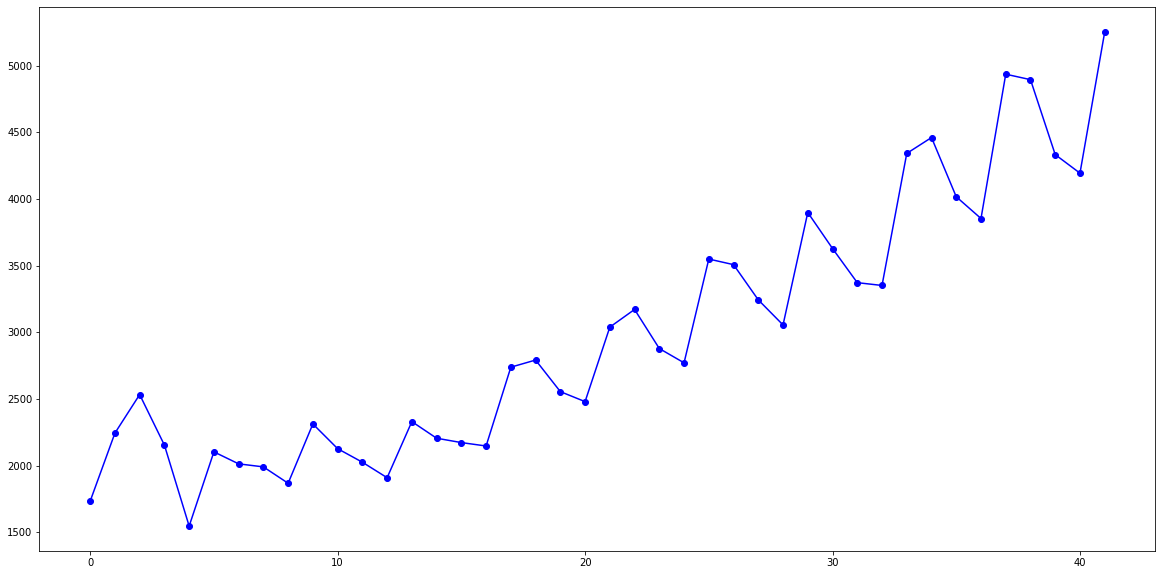

In [15]:
coke1.Sales.plot(figsize=(20,10),color='blue',marker='o');

There is an increase in trend (exponential)

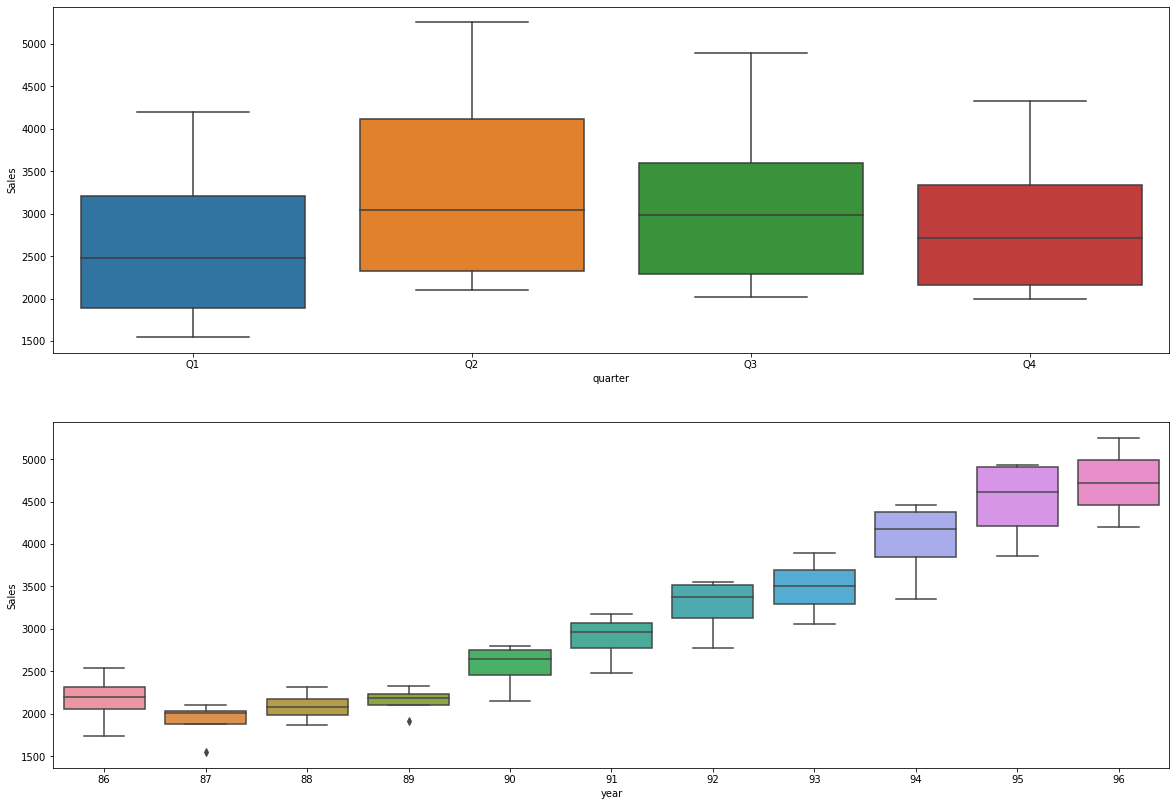

In [16]:
plt.figure(figsize=(20,14))

plt.subplot(2,1,1)
sns.boxplot(coke.quarter,coke.Sales)
plt.subplot(2,1,2)
sns.boxplot(coke.year,coke.Sales)

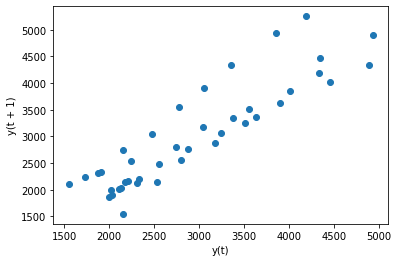

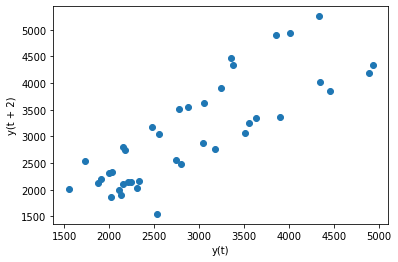

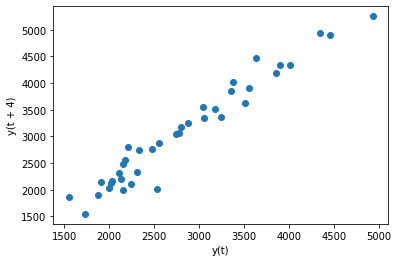

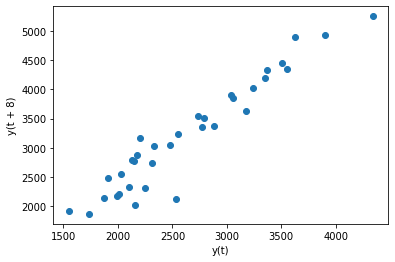

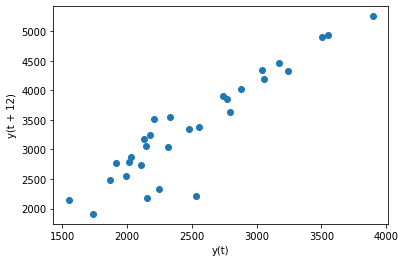

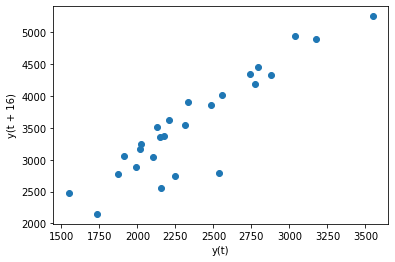

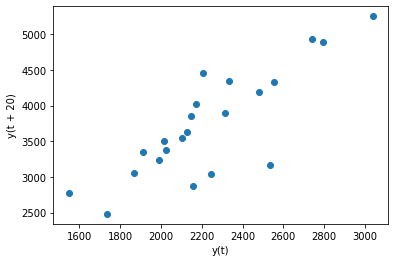

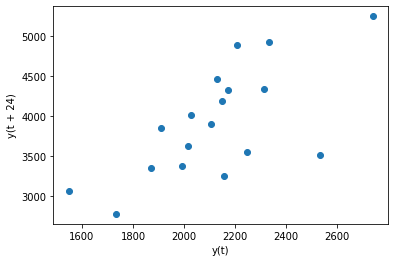

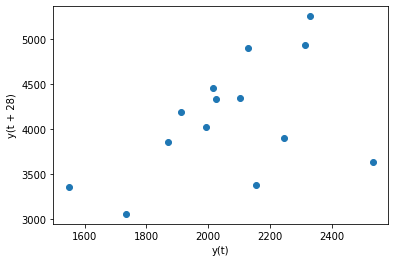

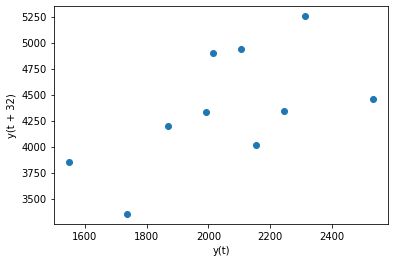

In [17]:
#Lag Plots
for i in [1,2,4,8,12,16,20,24,28,32]:
    lag_plot(coke1.Sales,lag=i)
    plt.show()

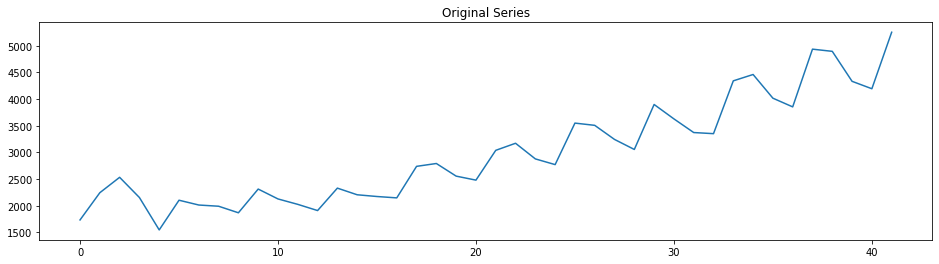

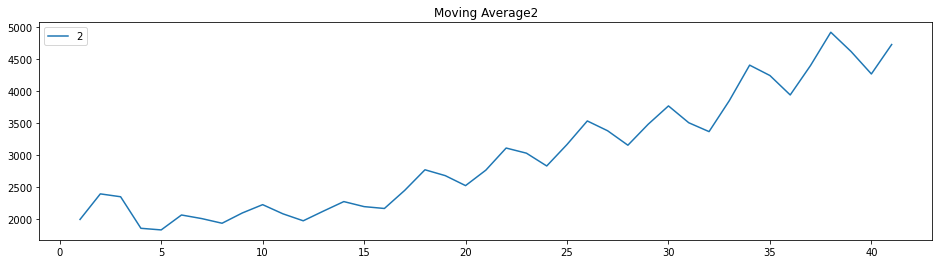

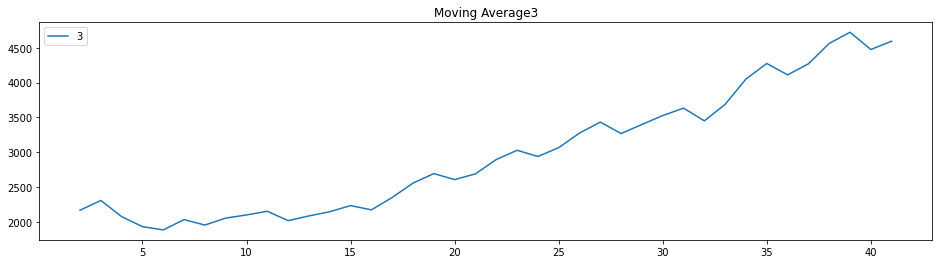

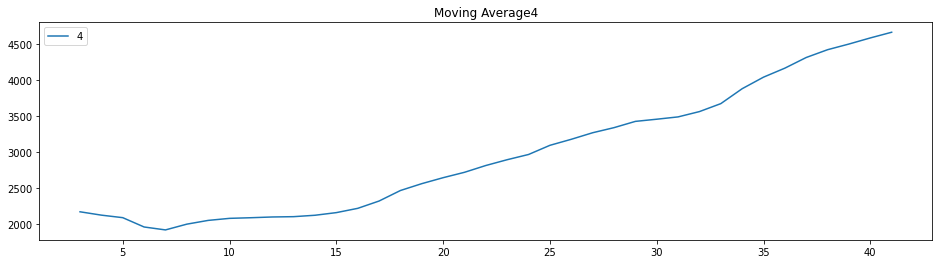

In [18]:
#Moving Average
plt.figure(figsize=(16,4))
coke.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    coke["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average"+str(i))
    plt.legend(loc='best')
    plt.show()

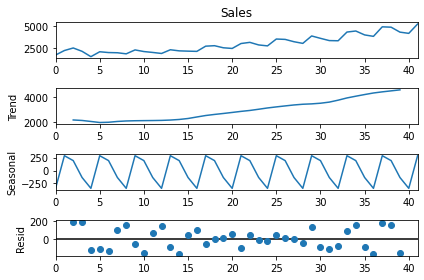

In [19]:
#Decomposition of Time-Series data
decompose_ts_add=seasonal_decompose(coke1.Sales,period=4)
decompose_ts_add.plot()
plt.show()

A seasonal pattern can be seen because of the regullar ups & downs.

There is an upward exponential trend in sales over time.

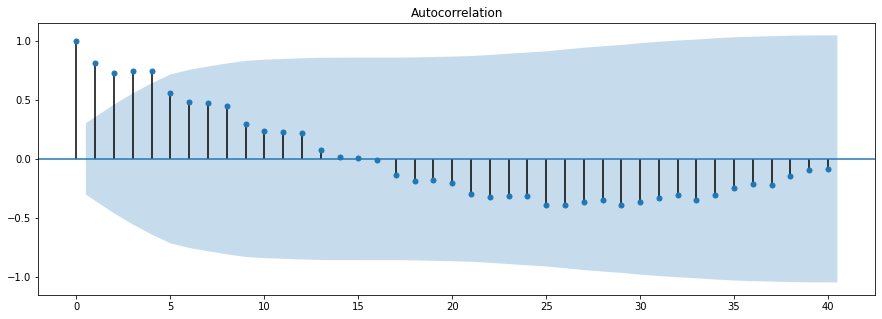

In [22]:
plt.rc("figure",figsize=(15,5)) 
tsa_plots.plot_acf(coke.Sales,lags=40)
plt.show()

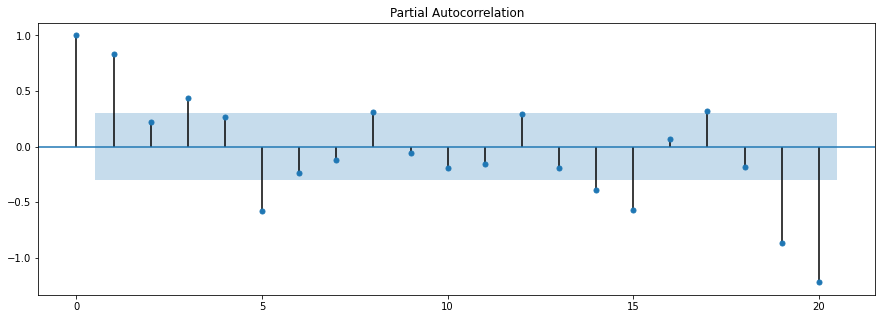

In [23]:
plt.rc("figure",figsize=(15,5))
tsa_plots.plot_pacf(coke.Sales,lags=20)
plt.show()

**Forecasting**

**Model Based Method**

In [24]:
Train=coke1.head(32)
Test=coke1.head(10)

In [25]:
#Linear Model
linear_model=smf.ols('Sales~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

336.2951713143498

In [26]:
#Exponential
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp=pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

310.1846957586862

In [27]:
#Quadratic
Quad=smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad=pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

274.05420458241963

In [33]:
#Additive Seasonality
add_sea=smf.ols('Sales ~ quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=Train).fit()
pred_add_sea=pd.Series(add_sea.predict(Test[[ 'quarter_Q1' ,'quarter_Q2','quarter_Q3', 'quarter_Q4']]))
rsme_add_sea=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rsme_add_sea

522.2023962258505

In [35]:
#Additive Quadratic Seasonality
add_sea_Quad=smf.ols('Sales~t+t_squared+quarter_Q1+quarter_Q2+quarter_Q3+quarter_Q4',data=Train).fit()
pred_add_sea_quad=pd.Series(add_sea_Quad.predict(Test[['quarter_Q1','quarter_Q2','quarter_Q3','quarter_Q4','t','t_squared']]))
rmse_add_sea_quad=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

170.94076055345016

In [30]:
#Multiplicative Seasonality
Mul_sea=smf.ols('log_sales~quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_sea=pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

466.5151627118026

In [31]:
#Multiplicative Additive Seasonality
Mul_Add_sea=smf.ols('log_sales~t+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_add_sea=pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

231.33130836224467

Comparing the results

In [36]:
data={"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,170.940761
6,rmse_Mult_add_sea,231.331308
2,rmse_Quad,274.054205
1,rmse_Exp,310.184696
0,rmse_linear,336.295171
5,rmse_Mult_sea,466.515163
3,rmse_add_sea,522.202396


**Forecasting**

**Data Driven Methods**

In [37]:
def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 

#Simple Exponential Method
ses_model=SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses=ses_model.predict(start=Test.index[0],end=Test.index[-1])
rmse_ses=rmse(Test.Sales, pred_ses) 
rmse_ses

300.07934579555223

In [38]:
#Holt's Method
hw_model=Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw=hw_model.predict(start=Test.index[0],end=Test.index[-1])
rmse_hw=rmse(Test.Sales, pred_hw) 
rmse_hw

391.135257745564

In [39]:
#Holts Winter Exponential smoothing with additive seasonality and additive trend
hwe_model_add_add=ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add=hwe_model_add_add.predict(start=Test.index[0],end=Test.index[-1])
rmse_hwe_add_add=rmse(Test.Sales, pred_hwe_add_add)
rmse_hwe_add_add

229.2893294371369

In [40]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add=ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add=hwe_model_mul_add.predict(start=Test.index[0],end=Test.index[-1])
rmse_mul_add=rmse(Test.Sales,pred_hwe_mul_add) 
rmse_mul_add

197.36677099987688

Comparing the results

In [42]:
data={"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data)
table_rmse=table_rmse.sort_values(by=['RMSE_Values']) 
table_rmse

,MODEL,RMSE_Values
4,add_sea_quad,170.940761
10,hwe_model_mul_add,197.366771
9,hwe_model_add_add,229.289329
6,Mult_add_sea,231.331308
2,Quad,274.054205
7,ses_model,300.079346
1,Exp,310.184696
0,linear,336.295171
8,hw_model,391.135258
5,Mult_sea,466.515163


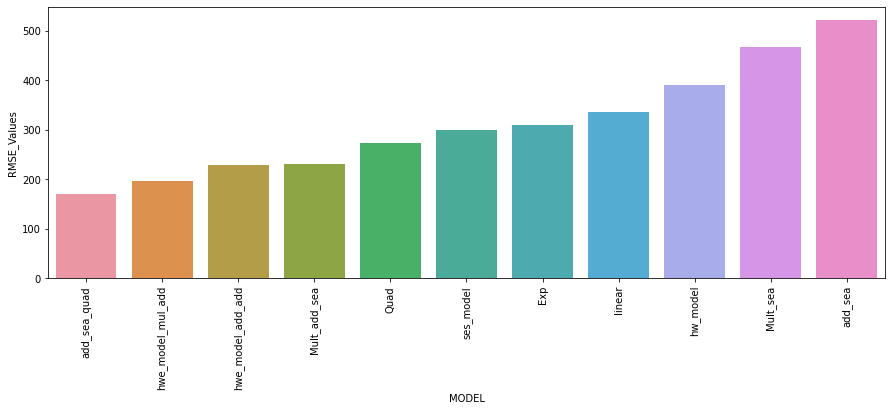

In [43]:
sns.barplot(table_rmse.MODEL,table_rmse.RMSE_Values)
plt.xticks(rotation=90)
plt.show()

Building final model by combining train & test based on Additive Seasonality Quadratic.

In [45]:
add_sea_Quad=smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred=add_sea_Quad.predict(coke1.tail()) #predicting on historic data
forecast_df=pd.DataFrame()

forecast_df['Actual Sales']=coke1.Sales.tail()
forecast_df['Predicted sales']=pred 

forecast_df

,Actual Sales,Predicted sales
37,4936.0,4705.724784
38,4895.0,4753.588072
39,4333.0,4557.724974
40,4194.0,4475.373006
41,5253.0,5257.826846


In [46]:
#creating new inputs for forecasting
new_df=pd.DataFrame() 
new_df['t']=np.arange(43,50,1) 
new_df['t_squared']=np.square(new_df.t)
new_df['quarter']=['Q3','Q4','Q1','Q2','Q3','Q4','Q1'] 
new_df=pd.get_dummies(new_df)
new_df

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,43,1849,0,0,1,0
1,44,1936,0,0,0,1
2,45,2025,1,0,0,0
3,46,2116,0,1,0,0
4,47,2209,0,0,1,0
5,48,2304,0,0,0,1
6,49,2401,1,0,0,0


In [47]:
add_sea_Quad=smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred=add_sea_Quad.predict(new_df)  
new_df['forcasted']=pred
new_df

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,forcasted
0,43,1849,0,0,1,0,5319.754557
1,44,1936,0,0,0,1,5137.955882
2,45,2025,1,0,0,0,5069.668337
3,46,2116,0,1,0,0,5866.186600
4,47,2209,0,0,1,0,5942.178733
5,48,2304,0,0,0,1,5774.444481
6,49,2401,1,0,0,0,5720.221359


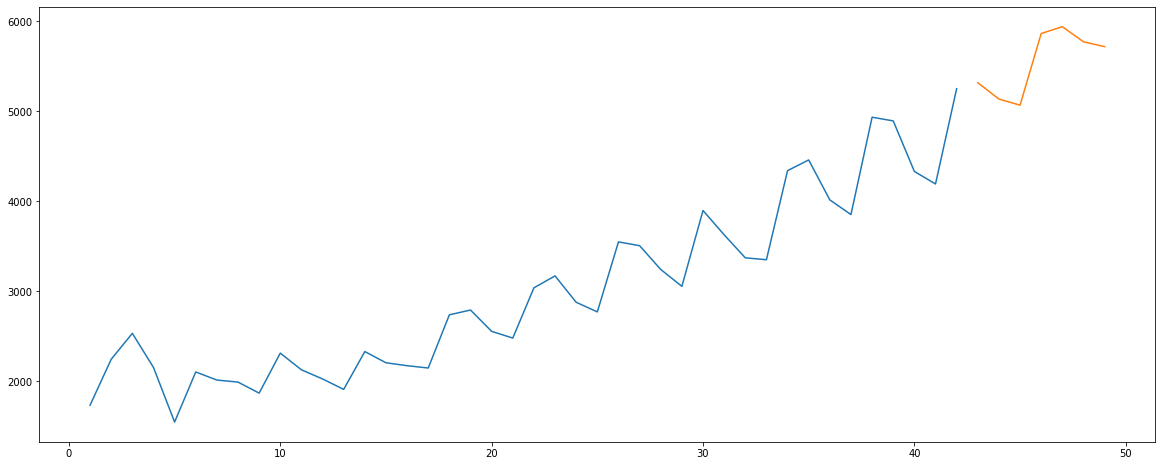

In [48]:
plt.figure(figsize=(20,8))
plt.plot(coke1.t,coke1.Sales)
plt.plot(new_df.t,new_df.forcasted)